# Implement DCGAN on Accelerometer Data

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

In [2]:
DATA_DIR = f'{os.path.expanduser("~")}/.delta/nursing_pt'
import math
class WindowedDatasetWithStrideAndModeOfLabel(torch.utils.data.Dataset):
    def __init__(self, nurse, windowsize=1, stride=1):
        self.windowsize = windowsize
        self.stride = stride
        self.channels = 3
        self.X,self.y = torch.load(f'{DATA_DIR}/{nurse}.pt')
        self.len = math.ceil(len(self.X)/self.stride)
        
        self.X = torch.cat([self.X,torch.zeros(self.windowsize-1,3)])

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return (
            self.X[(idx*self.stride):(idx*self.stride)+self.windowsize].transpose(0,1),
            self.y[(idx*self.stride):(idx*self.stride)+self.windowsize].mode().values
        )

def load_nursing_5_class(nurses='all', winsize=2001, test_size=0.25, batch_size=512, stride=1, split=None):
    not_labeled = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
    unlabled_sessions = set.intersection(set(nurses), not_labeled)
    if unlabled_sessions:
        raise ValueError(f"Session indexes {unlabled_sessions} are not labled")

    if nurses == 'all':
        nurses = list(range(11, 71))

    if stride == 'partition':
        stride = winsize
    
    if test_size == 1:
        dev_idx = nurses
        devloader = DataLoader(dataset=ConcatDataset([WindowedDatasetWithStrideAndModeOfLabel(nurse=idx,windowsize=winsize,stride=stride) for idx in dev_idx]),batch_size=batch_size,shuffle=False)
        return None, devloader
    elif test_size == 0:
        train_idx = nurses
        trainloader = DataLoader(dataset=ConcatDataset([WindowedDatasetWithStrideAndModeOfLabel(nurse=idx,windowsize=winsize,stride=stride) for idx in train_idx]),batch_size=batch_size,shuffle=True)
        return trainloader, None
    
    if split:
        train_idx, dev_idx = split
        if set(train_idx).intersection(set(dev_idx)):
            raise ValueError(f"Train and dev indexes overlap")
        if set.intersection(set(train_idx).union(set(dev_idx)), not_labeled):
            raise ValueError(f"Some indexes are not labled")
    else:
        train_idx, dev_idx = train_test_split(nurses, test_size=test_size, random_state=0)
        print(dev_idx)
    trainloader = DataLoader(dataset=ConcatDataset([WindowedDatasetWithStrideAndModeOfLabel(nurse=idx,windowsize=winsize,stride=stride) for idx in train_idx]),batch_size=batch_size,shuffle=True)
    devloader = DataLoader(dataset=ConcatDataset([WindowedDatasetWithStrideAndModeOfLabel(nurse=idx,windowsize=winsize,stride=stride) for idx in dev_idx]),batch_size=batch_size,shuffle=False)
    
    return trainloader, devloader

In [3]:
workers = 2         # Number of workers for dataloader
batch_size = 128    # Batch size during training
window_size = 1024  # Spatial length of data
nc = 3              # Number of channels
nz = 100            # Size of z latent vector (i.e. size of generator input)
ngf = 64            # Size of feature maps in generator
ndf = 64            # Size of feature maps in discriminator
num_epochs = 5      # Number of training epochs
lr = 0.0002         # Learning rate for optimizers
beta1 = 0.5         # Beta1 hyperparameter for Adam optimizers
ngpu = 2            # Number of GPUs available. Use 0 for CPU mode.
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Data

In [4]:
dataloader,_ = load_nursing_5_class(
    nurses='all',
    winsize=window_size,
    test_size=0,
    batch_size=batch_size,
    stride=window_size // 2
)

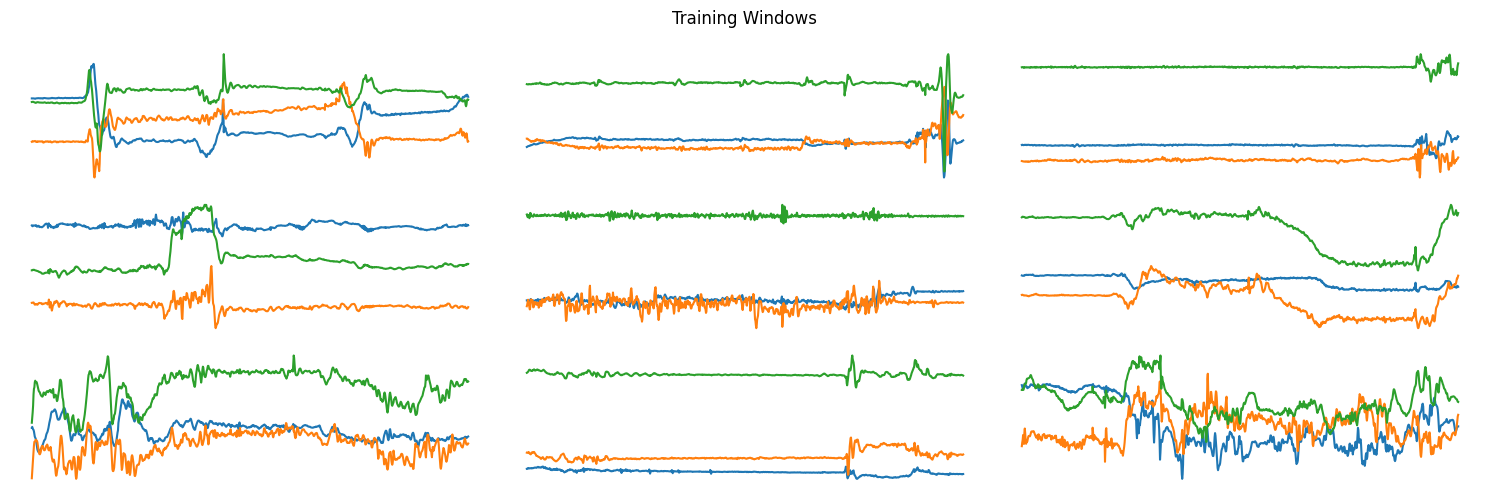

In [5]:
real_batch = next(iter(dataloader))
fig, axes = plt.subplots(3, 3, figsize=(15, 5))
plt.suptitle("Training Windows")
for i in range(9):
    axes.flatten()[i].plot(real_batch[0][i,0].numpy())
    axes.flatten()[i].plot(real_batch[0][i,1].numpy())
    axes.flatten()[i].plot(real_batch[0][i,2].numpy())
    axes.flatten()[i].axis("off")
plt.tight_layout()

# Models

In [6]:
# Weight initialization - call on model to initialize weights with N(0, 0.02)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator

In [7]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input Z is (nz) x 1, going into a convolution
            nn.ConvTranspose1d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm1d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4
            nn.ConvTranspose1d(ngf * 8, ngf * 4, 4, 4, 0, bias=False),
            nn.BatchNorm1d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16
            nn.ConvTranspose1d( ngf * 4, ngf * 2, 4, 4, 0, bias=False),
            nn.BatchNorm1d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 64
            nn.ConvTranspose1d( ngf * 2, ngf, 4, 4, 0, bias=False),
            nn.BatchNorm1d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 256
            nn.ConvTranspose1d( ngf, nc, 4, 4, 0, bias=False),
            # nn.Tanh()
            # state size. (nc) x 1024
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose1d(100, 512, kernel_size=(4,), stride=(1,), bias=False)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose1d(512, 256, kernel_size=(4,), stride=(4,), bias=False)
      (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose1d(256, 128, kernel_size=(4,), stride=(4,), bias=False)
      (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose1d(128, 64, kernel_size=(4,), stride=(4,), bias=False)
      (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose1d(64, 3, kernel_size=(4,), stride=(4,), bias=False)
    )
  )
)


## Discriminator

In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 1024
            nn.Conv1d(nc, ndf, 4, 4, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 256
            nn.Conv1d(ndf, ndf * 2, 4, 4, 1, bias=False),
            nn.BatchNorm1d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 64
            nn.Conv1d(ndf * 2, ndf * 4, 4, 4, 1, bias=False),
            nn.BatchNorm1d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 32
            nn.Conv1d(ndf * 4, ndf * 8, 4, 4, 1, bias=False),
            nn.BatchNorm1d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 32
            nn.Conv1d(ndf * 8, 1, 4, 1, 0, bias=False),
            # nn.Sigmoid()
            # state size. 1 x 1
        )

    def forward(self, input):
        return self.main(input)

In [10]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

DataParallel(
  (module): Discriminator(
    (main): Sequential(
      (0): Conv1d(3, 64, kernel_size=(4,), stride=(4,), padding=(1,), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv1d(64, 128, kernel_size=(4,), stride=(4,), padding=(1,), bias=False)
      (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv1d(128, 256, kernel_size=(4,), stride=(4,), padding=(1,), bias=False)
      (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv1d(256, 512, kernel_size=(4,), stride=(4,), padding=(1,), bias=False)
      (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Conv1d(512, 1, kernel_size=(4,), stride=(1,), bias=False)
    )
  )
)


# Loss and Optimizers

In [11]:
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
# optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
# optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.RMSprop(netD.parameters(), lr=0.00005)
optimizerG = optim.RMSprop(netG.parameters(), lr=0.00005)

# Train

In [12]:
sig_list = []
G_losses = []
D_losses = []
iters = 0

netD.train()
netG.train()

num_epochs = 1000
for epoch in (pbar := tqdm(range(num_epochs))):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_batch = data[0].to(device)
        b_size = real_batch.size(0)

        noise = torch.randn(b_size, nz, 1, device=device) # b x nz x 1
        fake = netG(noise).detach()
        D_x = netD(real_batch)
        D_G_z1 = netD(fake)
        loss_D = -torch.mean(D_x) + torch.mean(D_G_z1)
        loss_D.backward()
        optimizerD.step()                       # Update D

        D_x = D_x.mean().item()
        D_G_z1 = D_G_z1.mean().item()

        # Clip weights of discriminator
        for p in netD.parameters():
            p.data.clamp_(-0.01, 0.01)

        ############################
        # (2) Update G network: maximize log(D(G(z))) to minimize log(1 - D(G(z)))
        ###########################
        if i % 5 == 0:
            netG.zero_grad()
            fake = netG(noise)
            D_G_z2 = netD(fake)
            loss_G = -torch.mean(D_G_z2)
            loss_G.backward()
            optimizerG.step()

            D_G_z2 = D_G_z2.mean().item()

        # Save Losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            sig_list.append(fake)
        iters += 1

    # if epoch % 10 == 0:
    # Output training stats
    # pbar.set_description(f'Loss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}\tD(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')
    pbar.set_description(f'Loss_D: {loss_D.item():.4f}\tLoss_G: {loss_G.item():.4f}\tD(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

Loss_D: -0.2837	Loss_G: 0.1306	D(x): 0.1530	D(G(z)): -0.1306 / -0.1306:   2%|▏         | 20/1000 [01:21<1:06:33,  4.07s/it]


KeyboardInterrupt: 

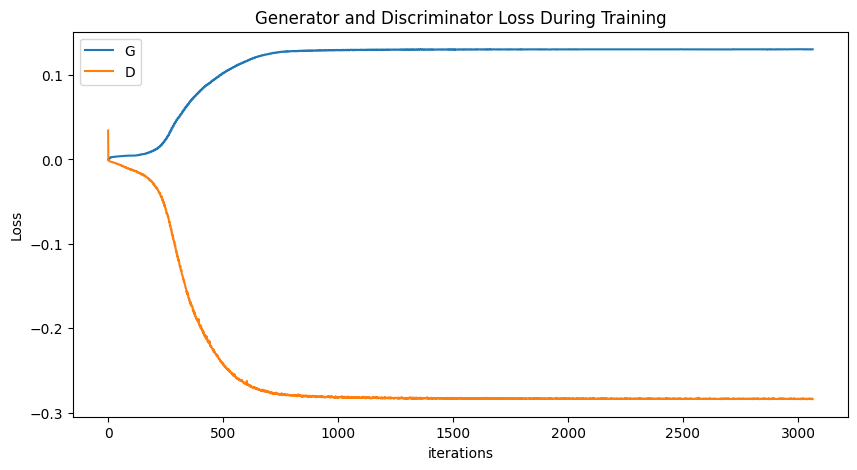

In [13]:
# Losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

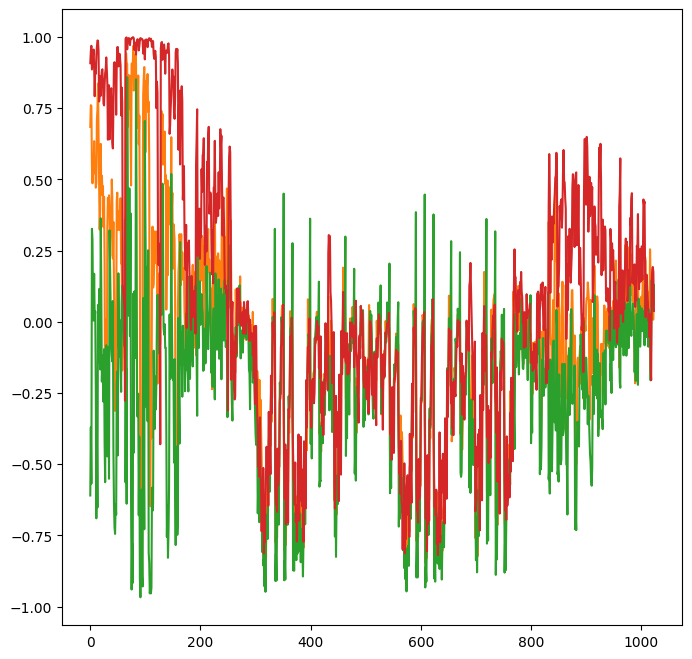

In [14]:
# Show animation of sig_list

# plt.suptitle("Generated Windows")
fig = plt.figure(figsize=(8,8))
ims = [plt.plot(i[0].T, animated=True) for i in sig_list]
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

# ims = []
# for sig in sig_list:
#     fig, axes = plt.subplots(3, 3, figsize=(15, 5))
#     for i in range(3):
#         for j in range(3):
#             axes[i,j].plot(sig[-1][i,0].numpy())
#             axes[i,j].plot(sig[-1][i,1].numpy())
#             axes[i,j].plot(sig[-1][i,2].numpy())
#             axes[i,j].axis("off")
#     ims.append(axes[i,j].lines)

HTML(ani.to_jshtml())

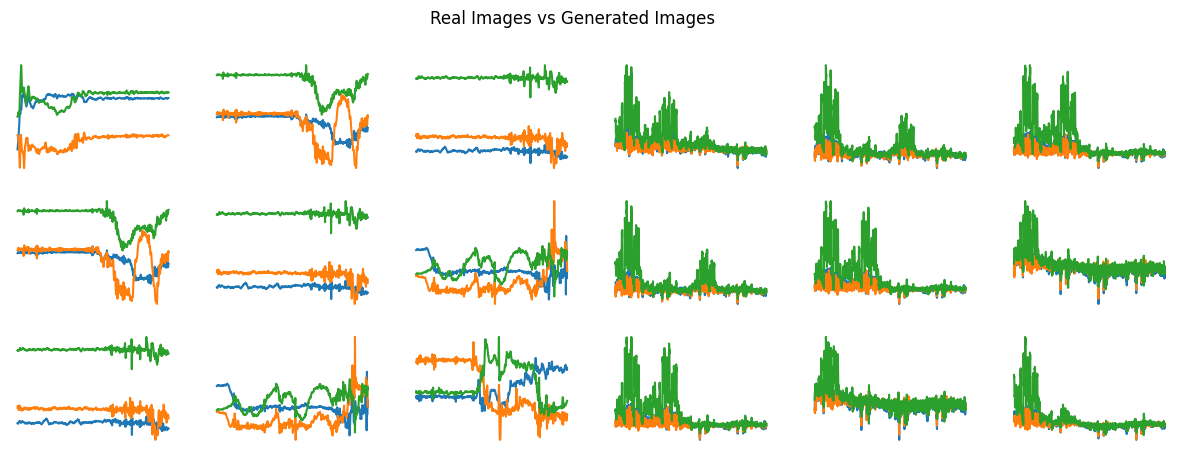

In [14]:
# Real Images vs. Fake Images
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))
fig, axes = plt.subplots(3, 6, figsize=(15, 5))

plt.suptitle("Real Images vs Generated Images")
# Plot the real images
for i in range(3):
    for j in range(3):
        axes[i,j].plot(real_batch[0][i+j,0].numpy())
        axes[i,j].plot(real_batch[0][i+j,1].numpy())
        axes[i,j].plot(real_batch[0][i+j,2].numpy())
        axes[i,j].axis("off")

# Plot the fake images from the last epoch
for i in range(3):
    for j in range(3,6):
        axes[i,j].plot(sig_list[-1][i+j,0].numpy())
        axes[i,j].plot(sig_list[-1][i+j,1].numpy())
        axes[i,j].plot(sig_list[-1][i+j,2].numpy())
        axes[i,j].axis("off")